In [1]:
import numpy as np
import pandas as pd
import math
import scipy
import matplotlib.pyplot as plt
from scipy.stats import norm,binom
from scipy.io import loadmat
from scipy.special import digamma, gammaln, gamma
from numpy.linalg import inv
#import cv2
from scipy import ndimage
import tensorflow as tf
import os, sys

In [ ]:
from utils.data_load import Image_data

In [ ]:
image_data = Image_data(npyfilename1 = 'PASCAL_data.npy',npyfilename2 = 'gray_scale.npy',
                        kernel_file_name = 'kernel1.mat')

In [ ]:
image_data.original_images.shape

In [ ]:
image_data.normalise()

In [ ]:
plt.imshow(image_data.conv_images[48542],cmap = 'gray')
plt.show()


In [ ]:
plt.imshow(image_data.original_images[48542],cmap = 'gray')
plt.show()

In [2]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

Using TensorFlow backend.


In [3]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard

In [4]:
x_test_noisy[0].shape

(28, 28, 1)

In [6]:
np.unique(x_train[298])

array([0.        , 0.01960784, 0.02352941, 0.04705882, 0.06666667,
       0.07058824, 0.07843138, 0.08627451, 0.09411765, 0.10196079,
       0.10588235, 0.14901961, 0.15294118, 0.16470589, 0.1764706 ,
       0.18431373, 0.19215687, 0.19607843, 0.25490198, 0.25882354,
       0.28627452, 0.3019608 , 0.3137255 , 0.37254903, 0.38039216,
       0.3882353 , 0.40784314, 0.41568628, 0.42352942, 0.43137255,
       0.4509804 , 0.45490196, 0.45882353, 0.49019608, 0.5019608 ,
       0.5647059 , 0.58431375, 0.5882353 , 0.60784316, 0.62352943,
       0.627451  , 0.63529414, 0.6392157 , 0.6509804 , 0.65882355,
       0.6627451 , 0.6862745 , 0.6901961 , 0.69411767, 0.74509805,
       0.7529412 , 0.7607843 , 0.78039217, 0.8039216 , 0.8117647 ,
       0.84313726, 0.85490197, 0.85882354, 0.87058824, 0.8745098 ,
       0.8901961 , 0.89411765, 0.9019608 , 0.9098039 , 0.91764706,
       0.92156863, 0.9647059 , 0.96862745, 0.9764706 , 0.98039216,
       0.9843137 , 0.9882353 , 0.99215686, 0.99607843], dtype=

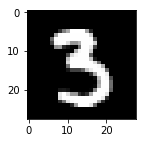

In [5]:
n = 10
plt.figure(figsize=(20, 2))


plt.imshow(x_train[298].reshape(28, 28),cmap = 'gray')

plt.show()

In [26]:
x_train[28].reshape(28, 28).shape

(28, 28)

In [11]:
np.max(x_test_noisy[298])

1.0

In [14]:
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [24]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 32)          9248      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 14, 14, 32)        0         
__________

In [26]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=100,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test_noisy, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/tb')])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 7s 118us/step - loss: 0.0942 - val_loss: 0.0944
Epoch 2/100
60000/60000 [==============================] - 7s 116us/step - loss: 0.0943 - val_loss: 0.0947
Epoch 3/100
60000/60000 [==============================] - 7s 116us/step - loss: 0.0942 - val_loss: 0.0937
Epoch 4/100
60000/60000 [==============================] - 7s 116us/step - loss: 0.0941 - val_loss: 0.0937
Epoch 5/100
60000/60000 [==============================] - 7s 116us/step - loss: 0.0941 - val_loss: 0.0941
Epoch 6/100
60000/60000 [==============================] - 7s 116us/step - loss: 0.0942 - val_loss: 0.0938
Epoch 7/100
60000/60000 [==============================] - 7s 116us/step - loss: 0.0941 - val_loss: 0.0940
Epoch 8/100
60000/60000 [==============================] - 7s 120us/step - loss: 0.0941 - val_loss: 0.0938
Epoch 9/100
60000/60000 [==============================] - 7s 116us/step - loss: 0.0941 - val_

KeyboardInterrupt: 

In [16]:
predict = autoencoder.predict(x_test_noisy)

In [23]:
x_train_noisy.shape


(60000, 28, 28, 1)

In [25]:
60000/28353

2.1161781822029413

In [ ]:
2